In [1]:
import cv2
import argparse
import imutils
import time
import scipy.io
# from sklearn.svm import SVC
import skvideo.io
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from scipy.ndimage import morphology as mp
from skimage.feature import canny
# from thundersvm import SVC
from sklearn import linear_model
from random import sample
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import image
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
import mahotas
from imutils.video import VideoStream
from imutils.video import FPS
import os
import pickle
import copy

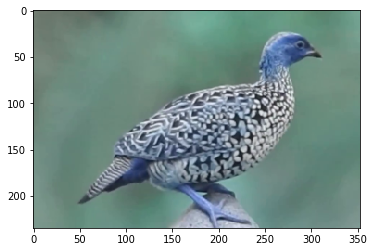

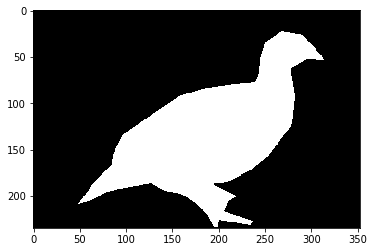

In [3]:
label=9
basepath = "training/"+str(label)+"/"
loadpath = basepath+"train/"
img = cv2.imread(loadpath+'frame.png');
# im_max = max(img.flatten())
# im_min = min(img.flatten())
# img = (img - im_min)/(im_max - im_min)
# imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# imgHSV=imgHSV[:,:,0:1]
sil = cv2.imread(loadpath+'gt.png');
# sil = cv2.cvtColor(sil, cv2.COLOR_BGR2HSV)
# sil=sil[:,:,0]
# [m,n] = img.shape
# [m1,n1] = sil.shape
# a=0
# b=0
# if(m1<m):
#     a = m 
plt.imshow(img),plt.show();
plt.imshow(sil*255),plt.show();
# cv2.imshow("Img",img);
# cv2.imshow("Sil",sil);
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [4]:
patches=[]
GT=[]
psize=8
patches = image.extract_patches_2d(img, (psize, psize))
# patches = image.extract_patches_2d(imgHSV, (psize, psize))
GT = image.extract_patches_2d(sil, (psize, psize))
X=[]
Y=[]
i=0;
print("Total Patches:"+str(len(patches)));
while i < len(patches):
# for i in range(len(patches)):
    a = patches[i].flatten()
#     a = (a - im_min)/(im_max - im_min)
    if(np.count_nonzero(GT[i])>=3):
        Y.append(1)
    else:
        Y.append(0)

    X.append(a)
    i=i+1


Total Patches:78888


In [5]:
ones = np.where(Y)[0]
num1 = int(0.8*len(ones))
zeroes = np.where(np.array(Y)==0)[0]
num2 = int(0.8*len(zeroes))
print(str(num1)+'/'+str(len(ones)))
print(str(num2)+'/'+str(len(zeroes)))

samp1 = sample(ones.tolist(),num1)
samp2 = sample(zeroes.tolist(),num2)

train_indices = np.array(samp1 + samp2)

test_X = np.delete(np.array(X),train_indices,axis=0)
test_Y = np.delete(Y,train_indices)
train_Y = np.array(Y)[train_indices.astype(int)]
train_X = np.array(X)[train_indices.astype(int)]

19915/24894
43195/53994


In [8]:
a = 1/len(train_X)

In [9]:
a

1.5845600469029773e-05

In [136]:
parameters = {'learning_rate': ['adaptive'],
 'loss': ['hinge'],
 'max_iter': [1000],
 'n_jobs': [-1],
 'penalty': ['l2'],
 'tol': [1e-06],
 'eta0':[1e-2,1e-4,1e-6]}

In [137]:
sgd = linear_model.SGDClassifier()
clf = GridSearchCV(sgd, parameters,scoring='accuracy', cv=5)

In [142]:
clf.fit(train_X,train_Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'loss': ['modified_huber', 'hinge'], 'penalty': ['l2', 'elasticnet'], 'learning_rate': ['optimal'], 'max_iter': [1000], 'tol': [1e-06], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [139]:
clf.cv_results_  

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([2.62839718, 1.87567754, 0.16378121]),
 'mean_score_time': array([0.00217538, 0.00213709, 0.00210905]),
 'mean_test_score': array([0.78300687, 0.82136861, 0.83805647]),
 'mean_train_score': array([0.79028242, 0.82532527, 0.83813234]),
 'param_eta0': masked_array(data=[0.01, 0.0001, 1e-06],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=['adaptive', 'adaptive', 'adaptive'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_loss': masked_array(data=['hinge', 'hinge', 'hinge'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_iter': masked_array(data=[1000, 1000, 1000],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_jobs': masked_array(data=[-1, -1, -1],
              mask=[False, False, False],
        fill_value=

In [99]:
clf.best_params_

{'eta0': 0.0001,
 'learning_rate': 'adaptive',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_jobs': -1,
 'penalty': 'l2',
 'tol': 1e-06}

In [140]:
parameters = {'loss':['modified_huber','hinge'],'penalty':['l2','elasticnet'],'learning_rate':['optimal'],'max_iter':[1000], 'tol':[1e-6],'n_jobs':[-1]}
# svc = SVC(gamma="scale")
sgd = linear_model.SGDClassifier()
# sgd = linear_model.SGDClassifier(alpha=a,loss='modified_huber',,epsilon=1e-4,max_iter=1000, tol=1e-6,n_jobs=-1)
# svc = SVC(kernel='rbf',gamma=1/(train_X[0].shape[0]*np.array(train_X).var()))
clf = GridSearchCV(sgd, parameters,scoring='accuracy', cv=5)

In [141]:

sgd = linear_model.SGDClassifier()
clf = GridSearchCV(sgd, parameters,scoring='accuracy', cv=5)

In [143]:
clf.cv_results_  

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([2.12937503, 3.75266166, 1.64925876, 3.98771696]),
 'mean_score_time': array([0.00213313, 0.00209632, 0.00253735, 0.00219684]),
 'mean_test_score': array([0.65952684, 0.77817349, 0.81567031, 0.7615365 ]),
 'mean_train_score': array([0.66196581, 0.77737515, 0.81812613, 0.76751186]),
 'param_learning_rate': masked_array(data=['optimal', 'optimal', 'optimal', 'optimal'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_loss': masked_array(data=['modified_huber', 'modified_huber', 'hinge', 'hinge'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_iter': masked_array(data=[1000, 1000, 1000, 1000],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_jobs': masked_array(data=[-1, -1, -1, -1],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=objec

In [103]:
clf.best_params_

{'learning_rate': 'optimal',
 'loss': 'modified_huber',
 'max_iter': 1000,
 'n_jobs': -1,
 'penalty': 'l2',
 'tol': 1e-06}

In [35]:
predictions = clf.predict(test_X)
accuracy_score(test_Y,predictions)

0.97769186893973

In [128]:
clf = linear_model.SGDClassifier(penalty='l2',loss='modified_huber',learning_rate='optimal',max_iter=1000, tol=1e-6,n_jobs=-1)
clf.fit(train_X, train_Y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
       max_iter=1000, n_iter=None, n_iter_no_change=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       tol=1e-06, validation_fraction=0.1, verbose=0, warm_start=False)

In [129]:
prediction = clf.predict(test_X)
accuracy_score(test_Y,prediction)

0.9023397761953205

In [30]:
clf = linear_model.SGDClassifier(eta0=1e-06,
                                 learning_rate= 'adaptive',
                                 loss= 'hinge',
                                 max_iter= 1000,
                                 n_jobs= -1,
                                 penalty='l2',
                                 tol= 1e-06)

In [31]:
clf.fit(train_X, train_Y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=1e-06, fit_intercept=True,
       l1_ratio=0.15, learning_rate='adaptive', loss='hinge',
       max_iter=1000, n_iter=None, n_iter_no_change=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       tol=1e-06, validation_fraction=0.1, verbose=0, warm_start=False)

In [6]:
clf = linear_model.SGDClassifier(penalty='l2',loss='modified_huber',learning_rate='optimal',max_iter=1000, tol=1e-6,n_jobs=-1)
clf.fit(X, Y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
       max_iter=1000, n_iter=None, n_iter_no_change=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       tol=1e-06, validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
clf.

In [145]:
def undesired_objects (image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[0]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

#     img2 = np.zeros(output.shape)
#     img2[output == max_label] = 255
#     plt.imshow(img2),plt.show();
    img2 = np.zeros(output.shape)
    img2[output == max_label] = 1
    return img2
#     cv2.imshow("Biggest component", img2)
#     cv2.waitKey()

Frame:1


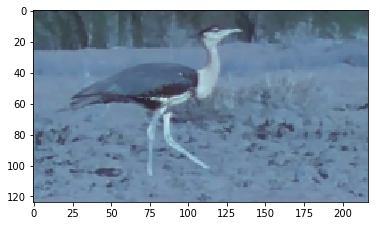

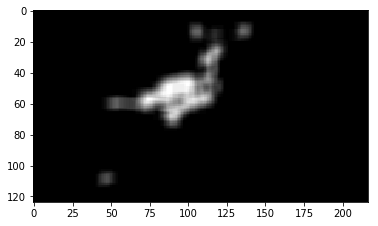

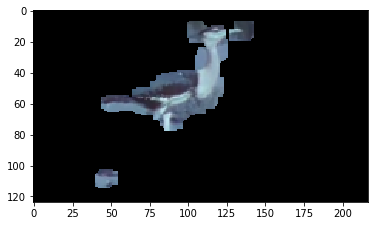

Frame:2


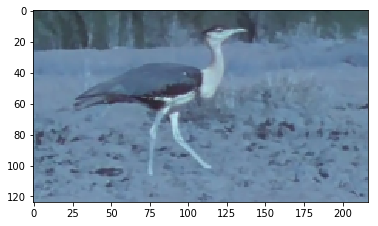

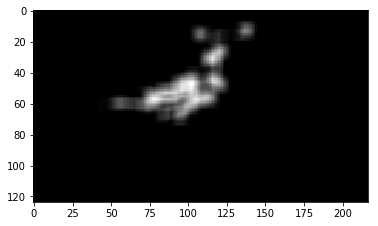

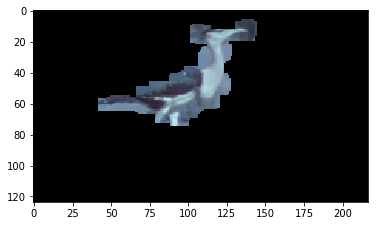

Frame:3


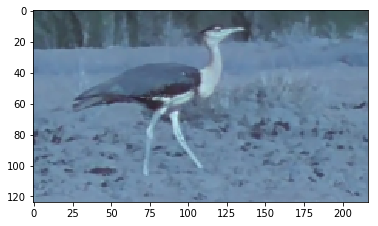

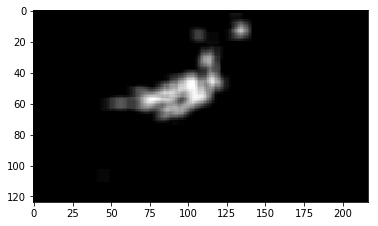

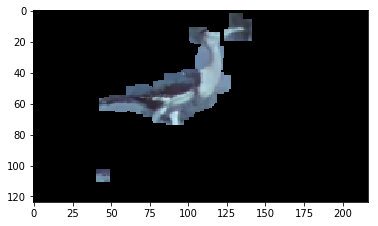

Frame:4


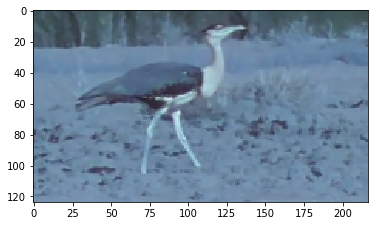

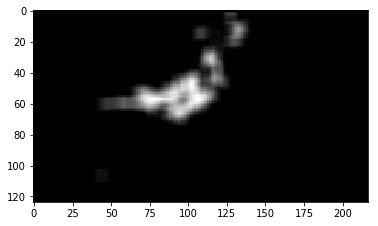

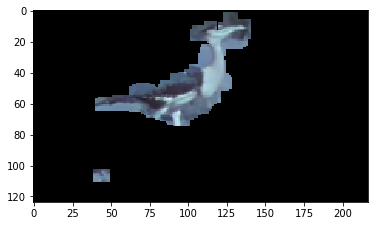

Frame:5


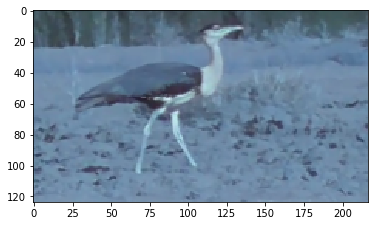

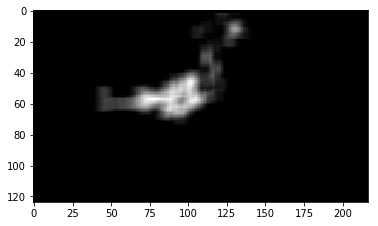

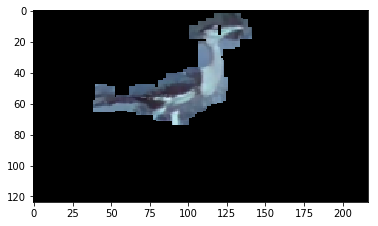

Frame:6


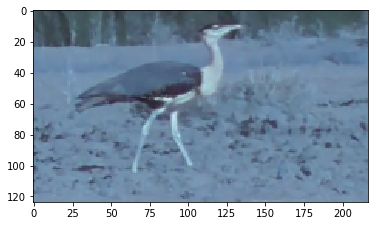

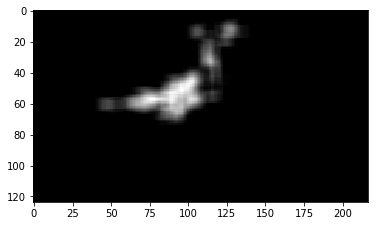

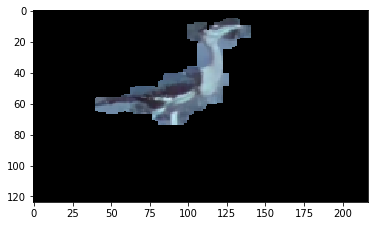

Frame:7


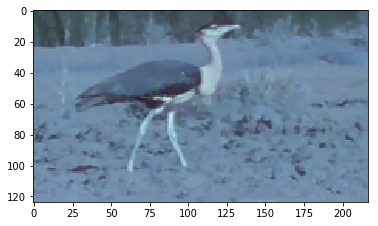

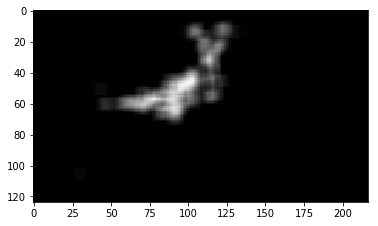

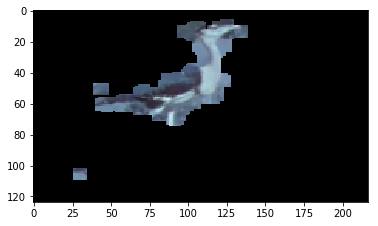

Frame:8


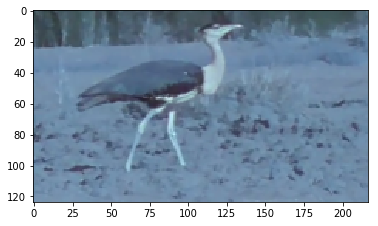

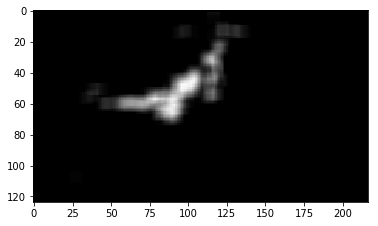

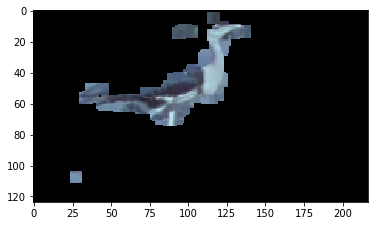

Frame:9


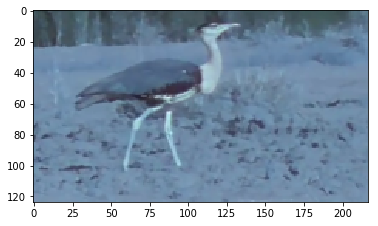

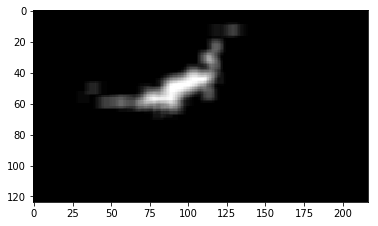

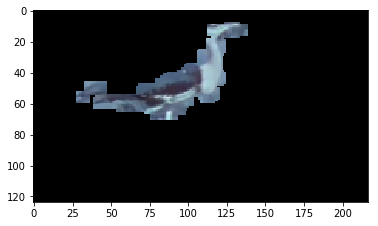

Frame:10


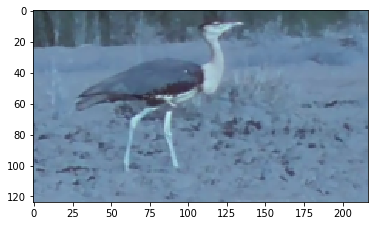

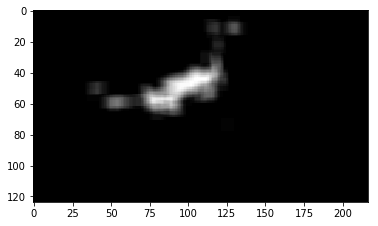

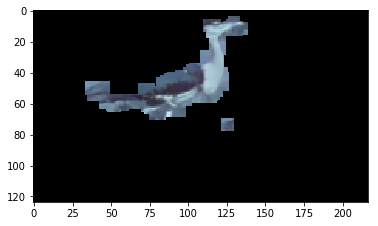

Frame:11


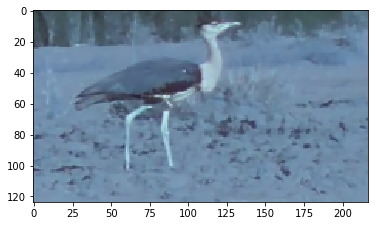

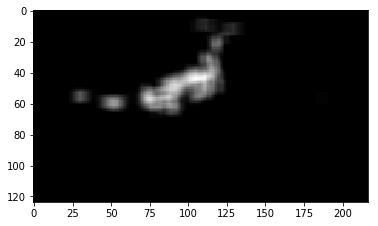

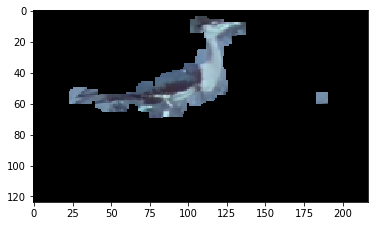

Frame:12


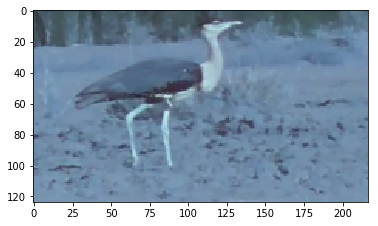

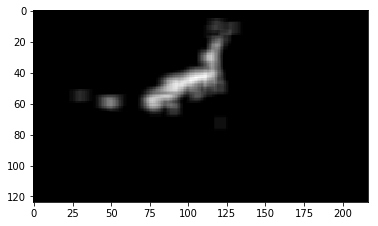

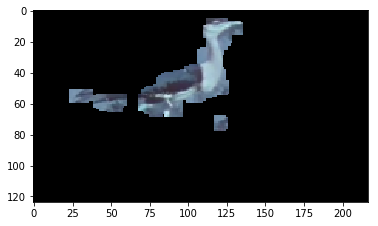

Frame:13


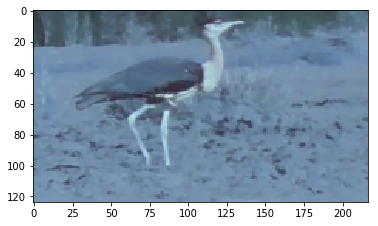

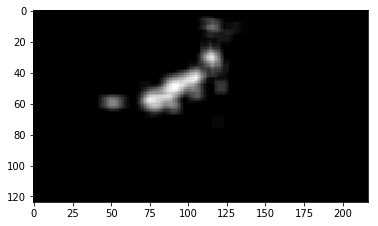

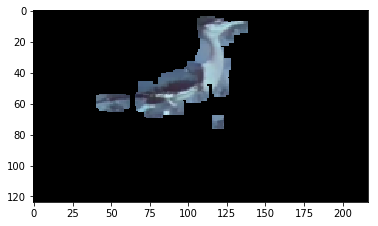

Frame:14


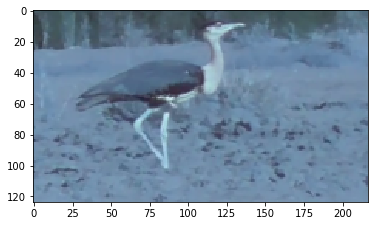

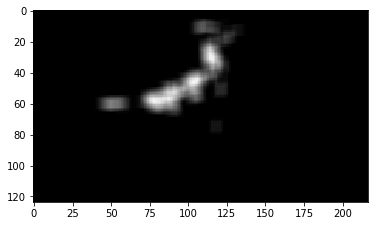

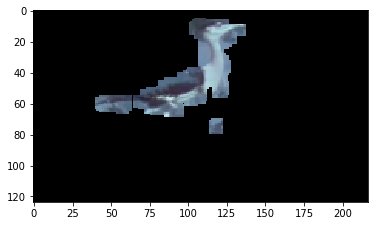

Frame:15


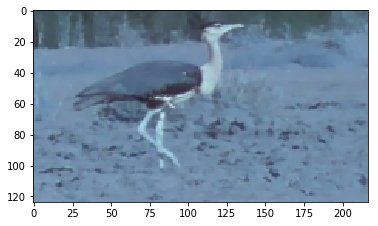

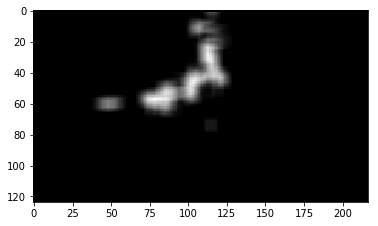

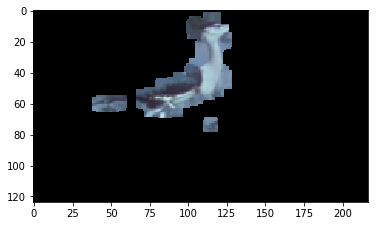

Frame:16


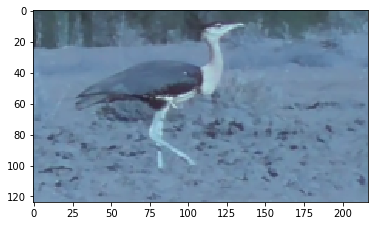

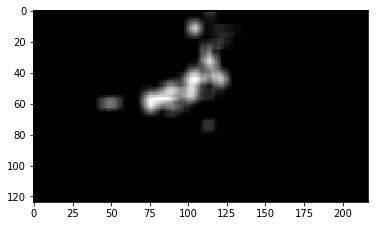

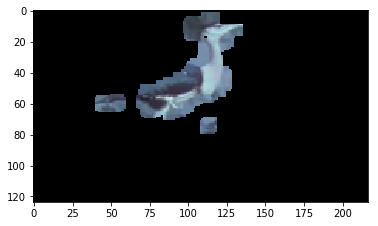

Frame:17


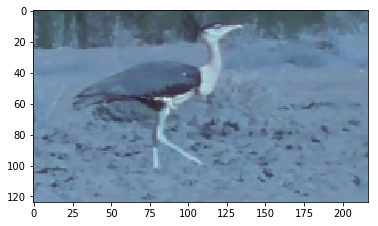

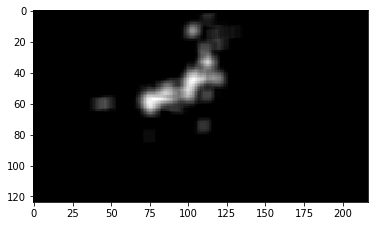

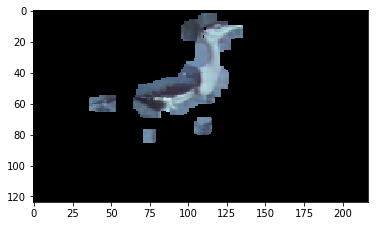

Frame:18


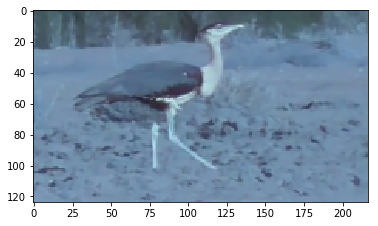

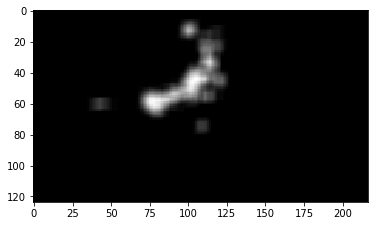

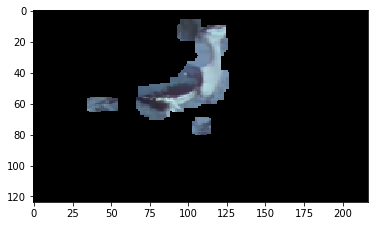

Frame:19


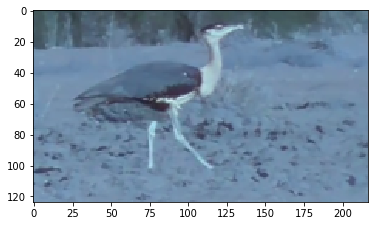

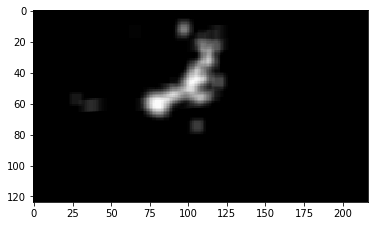

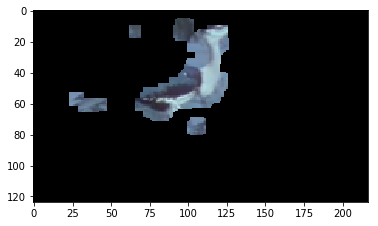

Frame:20


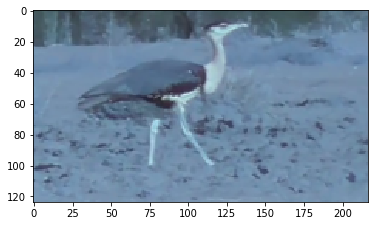

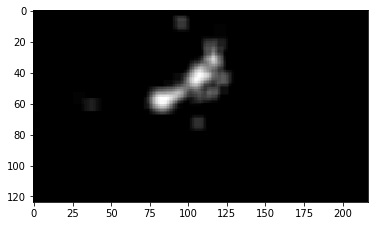

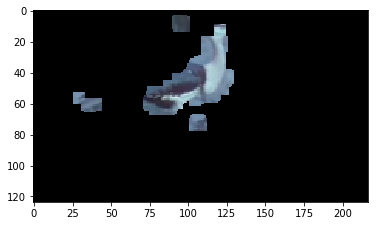

In [146]:
##### Testing for stride 1 ########
basepath = "training/"+str(label)+"/"
loadpath = basepath+"test/"
storepath = basepath+"output/"
if not os.path.exists(storepath):
    os.mkdir(storepath)
for n in range(1,21):
    print("Frame:"+str(n));
    next_img = cv2.imread(loadpath+'next_frame'+str(n)+'.png');
#     im_max = max(next_img.flatten())
#     im_min = min(next_img.flatten())
#     next_img = (next_img - im_min)/(im_max - im_min)
#     next_img_hsv = cv2.cvtColor(next_img, cv2.COLOR_BGR2HSV)
#     next_img_hsv = next_img_hsv[:,:,0:1]
    plt.imshow(next_img),plt.show();
    
    next_patches = image.extract_patches_2d(next_img, (psize, psize))
#     next_patches = image.extract_patches_2d(next_img_hsv, (psize, psize))
    TEST=[]
    for i in range(len(next_patches)):
        a = next_patches[i].flatten()
        TEST.append(a)
#     predictions = svc.predict(TEST)
    predictions = clf.predict(TEST)
    mask = np.zeros_like(next_patches)
    for i in range(len(predictions)):
        if(predictions[i]==1):
            mask[i] = mask[i] + 1
    ## Using thresholding on the image
    reconstructed = []
    reconstructed = image.reconstruct_from_patches_2d(mask, next_img.shape)
    plt.imshow(reconstructed),plt.show();
#     ret,thresh1 = cv2.threshold(reconstructed,0.01,1,cv2.THRESH_BINARY)
#     plt.imshow(thresh1),plt.show();
    
    mask2 = reconstructed.astype(np.bool)
    silhouette = np.zeros_like(next_img)
    silhouette[mask2] = next_img[mask2]
    
    ## Using maximally connected components on the image
#     reconstructed = []
#     reconstructed = image.reconstruct_from_patches_2d(mask, next_img.shape)
#     plt.imshow(reconstructed),plt.show();
#     mask2 = reconstructed.astype(np.bool)
#     silhouette = np.zeros_like(next_img)
#     silhouette[mask2] = next_img[mask2]
    
#     gray_sil = cv2.cvtColor(silhouette, cv2.COLOR_BGR2GRAY)
#     connected_mask = undesired_objects(gray_sil)
#     stacked_img = np.stack((connected_mask,)*3, axis=-1)
    
#     plt.imshow(stacked_img),plt.show();
    
#     mask = stacked_img.astype(np.bool)
#     silhouette = np.zeros_like(next_img)
#     silhouette[mask] = next_img[mask]
    
    plt.imshow(silhouette),plt.show();
    cv2.imwrite(storepath+'silhouette_frame'+str(n)+'.png',silhouette);

In [41]:
from sklearn import linear_model
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(train_X, train_Y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [44]:
prediction = clf.predict(test_X)

In [45]:
accuracy_score(test_Y,prediction)

0.974649851067875

In [10]:
silhouette.shape

(240, 353, 3)

error: OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.hpp:261: error: (-2:Unspecified error) in function 'cv::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::Set<3, 4>; VDcn = cv::Set<1>; VDepth = cv::Set<0, 2, 5>; cv::SizePolicy sizePolicy = (cv::SizePolicy)2u; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [16]:
silhouette[:,:,0].shape

(240, 353)